# Mendelian Randomization using the generated simulated data

## Simulate dataset for further MR analysis

In [122]:
import os
import numpy as np
import itertools
import pandas as pd
from scipy.sparse import load_npz
from itertools import combinations
import pdb

class GeneticSimulation:
    
    def __init__(self, dataset_size=10027, num_exposures=5, num_outcomes=3, seed=59):
        self.dataset_size = dataset_size
        self.num_exposures = num_exposures
        self.num_outcomes = num_outcomes
        self.num_causal_variants = int(dataset_size * 0.05)
        self.num_variables = num_exposures + num_outcomes
        self.rng = np.random.default_rng(seed=seed)
        self.LD_sparse = None
        self.h2 = 0.1
        self.pleiotropy_prop = 0.1
        self.prop_directionnal = 0.5
        # Generate correlated_effect matrix once during initialization
        #self.correlated_effect = self.generate_correlated_effect_matrix(
        #    num_rows=self.num_exposures, num_columns=self.num_outcomes,
        #    null_prob=0.5, low=0.1, high=0.3, seed=self.rng.integers(0, 1000)
        #)
        # Save the correlated_effect matrix as a NumPy file
        #np.savetxt('correlated_effect_matrix.csv', self.correlated_effect, delimiter='\t')

        

    def load_LD_sparse(self, file_path):
        self.LD_sparse = load_npz(file_path)
        
    def set_causal_variants(self, pleiotropy_prop):
        """
        Set the causal variants for exposures in the simulated dataset.
        Parameters:
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        Returns:
        - np.ndarray: Array containing lists of causal variants for each exposure.
        """
        
        pleio = []
        
        if pleiotropy_prop == 0:
            all_causal_variants = []
            # Choose significant variants for all exposures
            all_variants = np.arange(self.dataset_size)
            causal_list = self.rng.choice(all_variants, size=self.num_causal_variants, replace=False)
            # Divide the list into exposures
            all_causal_variants = np.array_split(causal_list, self.num_exposures)
    
        if pleiotropy_prop > 0:
            all_causal_variants = [[] for _ in range(self.num_exposures)]
            # Generate all pairs of exposures
            exposure_pairs = list(itertools.combinations(range(self.num_exposures), 2))
            # Calculate the number of pleiotropic variants per pair
            causal_variants_per_exposure = int(self.num_causal_variants / self.num_exposures)
            pleiotropic_variant_count_per_pair = int((causal_variants_per_exposure * pleiotropy_prop) / (self.num_exposures - 1))
            

            # Assign pleiotropic variants to each pair
            for pair in exposure_pairs:
                pleiotropic_variants_for_pair = self.rng.choice(self.dataset_size, size=pleiotropic_variant_count_per_pair, replace=False)
                pleio.append(pleiotropic_variants_for_pair)
                # Add these pleiotropic variants to the exposures in the pair
                for exposure in pair:
                    all_causal_variants[exposure] = np.unique(np.concatenate((all_causal_variants[exposure], pleiotropic_variants_for_pair)))
                    
            # Assign unique variants to each exposure
            for exposure_index in range(self.num_exposures):
                unique_variant_count = causal_variants_per_exposure - len(all_causal_variants[exposure_index])

                unique_variants = self.rng.choice(self.dataset_size, size=unique_variant_count, replace=False)

                all_causal_variants[exposure_index] = np.unique(np.concatenate((all_causal_variants[exposure_index], unique_variants)))            

        return all_causal_variants,pleio

    def generate_correlated_effect_matrix(self, num_rows=100, num_columns=3, null_prob=0.5, low=0.1, high=0.3, seed=None):
        # NOTE: THIS FUNCTION WILL NOT BE USED IN THIS TUTORIAL, correlated_effect will be predifined in the testing code 
        """
        Generate a correlated_effect matrix with random values and introduce variability.

        Parameters:
        - num_rows (int): Number of rows in the matrix.
        - num_columns (int): Number of columns in the matrix.
        - null_prob (float): Probability of setting an effect to zero.
        - low (float): Lower bound for random values.
        - high (float): Upper bound for random values.
        - seed (int): Seed for random number generation.

        Returns:
        - np.ndarray: Correlated_effect matrix with random values and variability.
        """
        num_rows = self.num_exposures if num_rows is None else num_rows
        num_columns = self.num_outcomes if num_columns is None else num_columns

        rng = np.random.default_rng(seed=seed)
        correlated_effect = rng.uniform(low=low, high=high, size=(num_rows, num_columns))

        # Introduce variability by randomly setting some effects to zero
        null_mask = rng.random(size=(num_rows, num_columns)) < null_prob
        correlated_effect[null_mask] = 0.0

        return correlated_effect

    
    def simulate_base_dataset(self, h2=0.5, pleiotropy_prop=0.1,prop_directionnal=0.5,seed = None):
        all_causal_variants,pleio = self.set_causal_variants(pleiotropy_prop)

        # Calculate the overall phenotypic variance using heritability (h2)
        sigma_causal = (1 + (self.dataset_size * h2) / self.num_causal_variants)
        # Simulate genetic components
        base_dataset = self.rng.normal(size=(self.dataset_size, self.num_variables))
        base_dataset = pd.DataFrame(base_dataset)

        # directionnal pleiotropy
        paires = list(combinations(range(self.num_exposures), 2))
        keep_pleio = []

        if prop_directionnal>0:
            i = 0
            all_pleio = np.concatenate(pleio)
            # we keep only x percent of the list to be directionnal
            keep_pleio = np.random.choice(all_pleio,int(prop_directionnal*len(all_pleio)), replace=False)
            # the rest is non directionnal (or "balanced" but we didn't really implement the balance yet)
            rm_pleio = list(set(all_pleio) - set(keep_pleio))
            # pdb.set_trace()
            # for each pleiotropic pair
            for pleio_exposure in pleio:
                # we keep directionnal pleiotropic variant
                significant_variants = list(set(pleio_exposure) - set(rm_pleio))
                # we gave them a big (more or less) causal effect
                sigmas_exposure = self.rng.normal(0, sigma_causal, (len(significant_variants),2))
                # we replace them in the base dataset with absolute value (same positive directionnal effect)
                colonnes = [self.num_outcomes+paires[i][0],self.num_outcomes+paires[i][1]]
                i += 1
                sigmas_exposure = abs(sigmas_exposure)
                index_negative = np.random.choice(a=range(len(sigmas_exposure)),size=int(len(sigmas_exposure)/2),replace=False)
                if len(index_negative) > 0:
                    sigmas_exposure[index_negative,:] *= -1
                base_dataset.iloc[significant_variants,colonnes] = sigmas_exposure
        # Apply causal variance to the subset of rows representing significant variants
        for exposure_index, significant_variants in enumerate(all_causal_variants):
            # we remove the directionnal pleiotropic variant (already treated)
            significant_variants = list(set(significant_variants)-set(keep_pleio))
            significant_variants = np.array(significant_variants, dtype = int)
            sigmas_exposure = self.rng.normal(0, sigma_causal, len(significant_variants))
            base_dataset.iloc[significant_variants, self.num_outcomes + exposure_index] = sigmas_exposure

       
        # Create column names for the DataFrame
        col_names = [f"Y_{i + 1}" for i in range(self.num_outcomes)] + [f"X_{i + 1}" for i in range(self.num_exposures)]
        # Create the final DataFrame
        base_dataset.columns = col_names
        # base_dataset_df = pd.DataFrame(base_dataset, columns=col_names)

        return base_dataset,all_causal_variants,pleio


    def propagate_LD_sparse(self, ld_sparse_matrix, effect_sizes):
        """
        Propagate LD effects through the simulated dataset.

        - ld_sparse_matrix (scipy.sparse.csr_matrix): Sparse matrix representing LD information.
        - effect_sizes (np.ndarray): Array of effect sizes.

        Returns:
        - np.ndarray: Array of propagated effect sizes.
        """
        propagated_effect_sizes = effect_sizes.copy()
        for i in range(ld_sparse_matrix.shape[0]):
            if np.any(ld_sparse_matrix.getrow(i).data):
                ld_row = ld_sparse_matrix.getrow(i).toarray().flatten()
                ld_adjustment = np.dot(ld_row, effect_sizes)
                propagated_effect_sizes += ld_adjustment

        return propagated_effect_sizes

    def simulate_outcomes(self, base_dataset_LD, correlated_effect, causal_variants,pleio):
        """
        Simulate outcomes based on the correlated_effect matrix.

        Parameters:
        - base_dataset_LD (pd.DataFrame): Simulated dataset with genetic components and LD propagation.
        - correlated_effect (np.ndarray): Array representing the correlation between outcomes and exposures.

        Returns:
        - pd.DataFrame: DataFrame containing simulated outcomes.
        """
        paires = list(combinations(range(self.num_exposures), 2))
        i = 0
        if len(pleio) > 0:
            for pleio_exposure in pleio:
                X = base_dataset_LD.iloc[pleio_exposure,[self.num_outcomes+paires[i][0],self.num_outcomes+paires[i][1]]]
                X = pd.DataFrame(X)
                matrix = np.random.uniform(low=0.1, high=0.5, size=(correlated_effect.shape[1], correlated_effect.shape[1]))
                noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
                outcomes = np.dot(X, correlated_effect[(paires[i][0],paires[i][1]),:])+noise
                base_dataset_LD.iloc[pleio_exposure,:self.num_outcomes] = outcomes
                i += 1
        for index,pleio_nopleio in enumerate(causal_variants):
            if len(pleio) > 0:
                nonpleio_exposures = list(set(pleio_nopleio) - set(np.concatenate(pleio))) # ordre ?
            else:
                nonpleio_exposures = list(set(pleio_nopleio))
            nonpleio_exposures = [int(x) for x in nonpleio_exposures]
            X = base_dataset_LD.iloc[nonpleio_exposures,self.num_outcomes+index]
            X = pd.DataFrame(X)
            matrix = np.random.uniform(low=0.1, high=0.5, size=(correlated_effect.shape[1], correlated_effect.shape[1]))
            noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
            outcomes = np.dot(X, correlated_effect[index,:].reshape(1, -1))+noise
            base_dataset_LD.iloc[nonpleio_exposures,:self.num_outcomes] = outcomes
            
        return base_dataset_LD
        
        
    def simulate_dataset(self, correlated_effect, pleiotropy_prop=0.1, h2=0.1,prop_directionnal=0.5, seed=None):
        """
        Simulate a complete final dataset including base genetic components, LD propagation, and outcomes.

        Parameters:
        - correlated_effect (np.ndarray): Array representing the correlation between outcomes and exposures.
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        - h2 (float): Heritability.
        - seed (int): Seed for random number generation.

        Returns:
        - pd.DataFrame: Simulated dataset with outcomes and exposures.
        - np.ndarray: Array containing lists of causal variants for each exposure.
        """
        if self.LD_sparse is None:
            raise ValueError("LD matrix not loaded. Use 'load_LD_sparse' method to load the LD matrix.")

        # Simulate the base dataset with genetic components and LD propagation
        base_dataset, all_causal_variants,pleio = self.simulate_base_dataset(h2=h2,
                                                                             pleiotropy_prop=pleiotropy_prop,
                                                                             seed=seed,
                                                                             prop_directionnal=prop_directionnal)
        # Simulate outcomes based on the correlated dataset
        base_dataset = self.simulate_outcomes(base_dataset, correlated_effect,all_causal_variants,pleio)

        # Update outcomes in the base dataset
        # base_dataset.iloc[np.concatenate(all_causal_variants).astype(int), :self.num_outcomes] = outcomes_df.values

        # Apply LD propagation to the entire dataset
        LD_sparse = self.LD_sparse.tocsr()
        base_dataset_LD = self.propagate_LD_sparse(LD_sparse, base_dataset)

        # Center exposures and outcomes by subtracting the mean of all variables
        mean_all_variables = base_dataset_LD.mean()
        base_dataset_LD -= mean_all_variables # une sorte de nomalisation
        
        # Rename columns
        col_names = [f"Y_{i + 1}" for i in range(self.num_outcomes)] + [f"X_{i + 1}" for i in range(self.num_exposures)]
        base_dataset_LD.columns = col_names

        # Return the base dataset and indices of significant variants
        return base_dataset_LD, all_causal_variants,pleio

    def compute_std_deviation(self, simulated_dataset):
        """
        Compute the standard deviation of the final simulated dataset.

        Parameters:
        - simulated_dataset (pd.DataFrame): The simulated dataset.

        Returns:
        - std_deviation (float): The standard deviation of the dataset.
        """

        # Compute the standard deviation of the entire dataset
        std_deviation = simulated_dataset.std()

        return std_deviation

    
    def verify_number_of_IVs(self, simulated_dataset):
        """
        Verify the number of independent variables (IVs) based on the specified criterion.

        Parameters:
        - simulated_dataset (pd.DataFrame): The simulated dataset.

        Returns:
        - num_IVs (int): The number of IVs that meet the specified criterion.
        - num_IVs_pleiotropic (int): The number of IVs with normalized betas > 5.45131 for at least two exposures.
        - IVs_indices (np.ndarray): The indices of identified IVs (row indices).
        """

        # Extract the beta values for the exposures only
        exposure_betas = simulated_dataset.iloc[:, self.num_outcomes:self.num_outcomes + self.num_exposures].values

        # Calculate the variance of the beta values
        variance_betas = np.var(exposure_betas, axis=0)
        # Calculate the normalized beta values using the variance
        normalized_betas = np.abs(exposure_betas / np.sqrt(variance_betas))

        # Identify IVs based on the threshold
        dict_IVs = {}
        for exposure in range(self.num_exposures): # self.num_exposures
            IVs_indices = np.where(np.abs(normalized_betas[:,exposure]) > 5.45131)[0]
            dict_IVs[f"X_{exposure+1}"] = IVs_indices

        # Count the number of identified IVs
        num_IVs = sum(len(valeurs) for valeurs in dict_IVs.values())
        # Identify pleiotropic IVs (normalized betas > 5.45131 for at least two exposures)
        pleiotropic_IVs_indices = np.where(np.sum(normalized_betas > 5.45131, axis=1) >= 2)[0]
        num_pleiotropic_IVs = len(pleiotropic_IVs_indices)

        return num_IVs, num_pleiotropic_IVs, dict_IVs, pleiotropic_IVs_indices

    def run_scenario(self, pleiotropy_prop, h2, num_datasets, prop_directionnal, parent_folder="PleioLin"):
        """
        Run a scenario of the genetic simulation for multiple datasets.

        Parameters:
        - pleiotropy_prop (float): Proportion of pleiotropic variants.
        - h2 (float): Heritability.
        - num_datasets (int): Number of datasets to simulate.
        - parent_folder (str): Parent folder to save results.

        Returns:
        - list: List of dictionaries containing information for each simulated dataset.
        """
        model_results = []
        
        # Create parent folder if it doesn't exist
        if not os.path.exists(parent_folder):
            os.makedirs(parent_folder)

        for dataset_num in range(1, num_datasets + 1):
            # Change the seed for each iteration
            seed_for_iteration = self.rng.integers(0, 2**31 - 1)
            
            # Run the simulation for a single dataset
            base_dataset, all_causal_variants,pleio = self.simulate_dataset(
                correlated_effect=correlated_effect,
                pleiotropy_prop=pleiotropy_prop,
                h2=h2,
                seed=seed_for_iteration,
                prop_directionnal=prop_directionnal
            )
            
            # Save the base dataset to a CSV file
            scenario_folder = f'Scenario{int(pleiotropy_prop * 100)}_h2{h2}'
            scenario_path = os.path.join(parent_folder, scenario_folder)
            if not os.path.exists(scenario_path):
                os.makedirs(scenario_path)
            base_dataset.to_csv(os.path.join(scenario_path, f'dataset_{dataset_num}.csv'), index=False)

            # Verify the number of IVs and get relevant information
            num_IVs, num_pleiotropic_IVs, IVs_indices, pleiotropic_IVs_indices = self.verify_number_of_IVs(base_dataset)

            # Compute the standard deviation of the final simulated dataset
            std_deviation = self.compute_std_deviation(base_dataset)

            # Save causal variants to CSV files
            # causal_variants_df = pd.DataFrame({'causal_variants': all_causal_variants})
            # causal_variants_df.to_csv(os.path.join(scenario_path, f'causal_variants_{dataset_num}.csv'), index=False)

            # Save IVs_indices to CSV for each dataset
            IVs_indices_df = pd.DataFrame({'IVs_indices': IVs_indices})
            IVs_indices_df.to_csv(os.path.join(scenario_path, f'IVs_indices_{dataset_num}.csv'), index=False)

            # Save pleiotropic_IVs_indices to CSV for each dataset
            pleiotropic_IVs_indices_df = pd.DataFrame({'pleiotropic_IVs_indices': pleiotropic_IVs_indices})
            pleiotropic_IVs_indices_df.to_csv(os.path.join(scenario_path, f'pleiotropic_IVs_indices_{dataset_num}.csv'), index=False)

            # Save std_deviation to CSV for each dataset
            pd.DataFrame({'std_deviation': [std_deviation]}).to_csv(os.path.join(scenario_path, f'std_deviation_{dataset_num}.csv'), index=False)

            # Save params.txt
            with open(os.path.join(scenario_path, 'params.txt'), 'w') as params_file:
                params_file.write(f"Pleiotropic Variants (%): {pleiotropy_prop * 100}\n")
                params_file.write(f"Heritability: {h2}\n")
                params_file.write(f"Seed for Iteration: {seed_for_iteration}\n")

            # Store the relevant information in a dictionary
            result = {
                "Pleiotropic Variants (%)": pleiotropy_prop * 100,
                "Heritability": h2,
                "Base Dataset": base_dataset,
                "Causal Variants": np.concatenate(all_causal_variants),
                "Divided CV": all_causal_variants,
                "IV Indices": IVs_indices,
                "Num IVs":num_IVs,
                "pleio":pleio,
                "num pleiotropic IVs": num_pleiotropic_IVs,
                "pleiotropic IVs indices": pleiotropic_IVs_indices,
                "Standard Deviation": std_deviation,
                "Seed for Iteration": seed_for_iteration
            }
            model_results.append(result)

        return model_results

In [123]:
genetic_simulator = GeneticSimulation()
genetic_simulator.load_LD_sparse("ld_matrix.npz")
correlated_effect = np.array([
                [0.15, 0.1, 0.2],
                [0.2, 0.15, 0.1],
                [0.15, 0.0, 0.0],
                [0.0, 0.25, 0.0],
                [0.0, 0.0, 0.25]
            ])
scenarios = [
    #{"pleiotropy_prop": 0, "h2": 0.1, "num_datasets": 10},
    #{"pleiotropy_prop": 0.5, "h2": 0.1, "num_datasets": 10},
    #{"pleiotropy_prop": 0, "h2": 0.5, "num_datasets": 10},
    #{"pleiotropy_prop": 0.5, "prop_directionnal":0, "h2": 1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "prop_directionnal":0, "h2": 1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "prop_directionnal":0.25, "h2": 1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "prop_directionnal":0.5, "h2": 1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "prop_directionnal":0.75, "h2": 1, "num_datasets": 10},
    {"pleiotropy_prop": 0.5, "prop_directionnal":1, "h2": 1, "num_datasets": 10}]
all_results = []
for scenario in scenarios:
    model_results = genetic_simulator.run_scenario(
        pleiotropy_prop=scenario["pleiotropy_prop"],
        h2=scenario["h2"],
        prop_directionnal=scenario["prop_directionnal"],
        num_datasets=scenario["num_datasets"],
        parent_folder="PleioLin"
    )
    all_results.extend(model_results)

/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n

/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n

/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:200: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n2cx347g5721npvk80000gq/T/ipykernel_918/2375299655.py:213: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise=self.rng.multivariate_normal(np.zeros(correlated_effect.shape[1]), matrix, X.shape[0])
/var/folders/3l/32m97f2n

In [124]:
# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(all_results)

In [29]:
results_df

,Pleiotropic Variants (%),Heritability,Base Dataset,Causal Variants,Divided CV,IV Indices,Num IVs,pleio,num pleiotropic IVs,pleiotropic IVs indices,Standard Deviation,Seed for Iteration
0,50.0,1,Y_1 Y_2 Y_3 X_1...,"[114.0, 142.0, 154.0, 206.0, 375.0, 410.0, 420...","[[114.0, 142.0, 154.0, 206.0, 375.0, 410.0, 42...","{'X_1': [142, 154, 375, 420, 568, 752, 1056, 1...",277,"[[2548, 3600, 5316, 4443, 5695, 5901, 9099, 38...",41,"[154, 160, 511, 764, 1056, 1131, 1548, 1615, 2...",Y_1 1.164953 Y_2 1.215860 Y_3 1.21906...,1887504394
1,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[118.0, 181.0, 207.0, 219.0, 258.0, 316.0, 327...","[[118.0, 181.0, 207.0, 219.0, 258.0, 316.0, 32...","{'X_1': [181, 207, 219, 258, 316, 327, 543, 62...",289,"[[9829, 9594, 1752, 8693, 9045, 4671, 9308, 10...",41,"[383, 483, 642, 770, 995, 1061, 1729, 1752, 27...",Y_1 1.171392 Y_2 1.172644 Y_3 1.16279...,1310579120
2,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[17.0, 20.0, 135.0, 258.0, 378.0, 454.0, 623.0...","[[17.0, 20.0, 135.0, 258.0, 378.0, 454.0, 623....","{'X_1': [17, 258, 378, 454, 623, 795, 949, 122...",300,"[[8014, 5816, 17, 795, 5638, 378, 6574, 9900, ...",45,"[17, 454, 487, 623, 795, 1140, 1348, 1780, 179...",Y_1 1.161008 Y_2 1.195332 Y_3 1.20915...,345379152
3,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[16.0, 75.0, 224.0, 385.0, 503.0, 598.0, 855.0...","[[16.0, 75.0, 224.0, 385.0, 503.0, 598.0, 855....","{'X_1': [16, 385, 598, 855, 979, 1004, 1100, 1...",279,"[[4711, 9293, 9984, 5593, 8635, 5944, 1413, 57...",49,"[347, 392, 855, 1004, 1243, 1728, 1766, 2177, ...",Y_1 1.214748 Y_2 1.182627 Y_3 1.21675...,31726349
4,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[171.0, 282.0, 499.0, 774.0, 811.0, 919.0, 978...","[[171.0, 282.0, 499.0, 774.0, 811.0, 919.0, 97...","{'X_1': [171, 282, 499, 774, 811, 978, 1842, 2...",276,"[[4771, 8223, 3489, 5086, 5704, 2927, 3270, 23...",38,"[389, 470, 499, 764, 851, 2222, 3266, 3297, 33...",Y_1 1.164597 Y_2 1.190785 Y_3 1.18076...,1370150312
5,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[85.0, 178.0, 216.0, 404.0, 549.0, 653.0, 678....","[[85.0, 178.0, 216.0, 404.0, 549.0, 653.0, 678...","{'X_1': [85, 178, 404, 678, 752, 857, 1042, 11...",261,"[[7173, 4219, 2526, 8694, 5602, 404, 4343, 468...",37,"[108, 178, 404, 752, 1042, 1176, 1688, 1768, 2...",Y_1 1.149616 Y_2 1.170369 Y_3 1.16246...,2067815927
6,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[11.0, 207.0, 244.0, 316.0, 659.0, 668.0, 879....","[[11.0, 207.0, 244.0, 316.0, 659.0, 668.0, 879...","{'X_1': [11, 316, 659, 668, 879, 1132, 1674, 2...",282,"[[9293, 8999, 3195, 316, 1674, 659, 9581, 2454...",40,"[296, 316, 549, 659, 879, 1132, 1200, 1315, 16...",Y_1 1.178081 Y_2 1.202178 Y_3 1.18827...,1150291426
7,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[43.0, 49.0, 114.0, 577.0, 725.0, 759.0, 976.0...","[[43.0, 49.0, 114.0, 577.0, 725.0, 759.0, 976....","{'X_1': [43, 114, 725, 976, 1313, 1513, 1911, ...",264,"[[2922, 3987, 8982, 2067, 7975, 976, 8677, 336...",34,"[212, 342, 350, 471, 725, 793, 976, 1671, 2065...",Y_1 1.137146 Y_2 1.170787 Y_3 1.24660...,395145997
8,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[273.0, 371.0, 420.0, 572.0, 621.0, 624.0, 698...","[[273.0, 371.0, 420.0, 572.0, 621.0, 624.0, 69...","{'X_1': [371, 420, 621, 624, 698, 979, 1074, 1...",268,"[[3470, 1234, 9664, 6234, 9550, 6245, 4266, 54...",36,"[596, 909, 1234, 1504, 1635, 1655, 1664, 1724,...",Y_1 1.153084 Y_2 1.135414 Y_3 1.21024...,2022013979
9,50.0,1,Y_1 Y_2 Y_3 X_1 ...,"[50.0, 73.0, 221.0, 222.0, 361.0, 999.0, 1022....","[[50.0, 73.0, 221.0, 222.0, 361.0, 999.0, 1022...","{'X_1': [73, 222, 999, 1022, 1162, 1205, 1233,...",257,"[[7832, 8890, 4025, 1769, 9287, 2136, 3882, 22...",42,"[9, 78, 189, 1162, 1769, 2017, 2062, 2159, 262...",Y_1 1.161596 Y_2 1.162042 Y_3 1.20721...,329049859


In [8]:
# # Split the DataFrame into chunks of "num_datasets" 
# chunk_size = 10
# chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

# # Compute the average number of significant variants (length of lists) and average number of IVs for each chunk
# avg_significant_variants = [np.mean([len((chunk['Causal Variants'].iloc[j])) for j in range(min(chunk_size, len(chunk)))]) for chunk in chunks]
# avg_ivs = [len(chunk['IV Indices'].mean()) for chunk in chunks]

# # Extract the IVs indices for Scenario 1 (index 0)
# IVs_indices_S1 = results_df['IV Indices'].iloc[1]
# # Extract the simulated dataset of effect sizes for Scenario 1 (index 0)
# base_dataset_S1 = results_df['Base Dataset'].iloc[1]
# # Keep only data for IVs
# dataset_S1 = base_dataset_S1.iloc[IVs_indices_S1]

# MR 1 exposure 1 outcome

In [133]:
import pandas as pd
import statsmodels.api as sm
import pdb

# Split the DataFrame into chunks of "num_datasets" 
chunk_size = 10
scenar = 4
chunk = results_df.iloc[chunk_size*scenar:chunk_size*(scenar+1),:]
#chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

dataset = chunk.loc[chunk_size*scenar,"Base Dataset"]
estimated_effects_matrix = pd.DataFrame(index=dataset.columns[3:], columns=dataset.columns[:3])
estimated_effects_matrix.iloc[:,:] = [[[] for i in range(3)] for j in range(5)]

for dataset_index in range(chunk_size*scenar,chunk_size*(scenar+1)):
    # Extract exposures and outcomes
    dataset = chunk.loc[dataset_index,"Base Dataset"]
    dict_IVs = chunk.loc[dataset_index,"IV Indices"]
    exposures = dataset.iloc[:, 3:]  # Assuming exposures are in columns X_1 to X_5
    outcomes = dataset.iloc[:, :3]   # Assuming outcomes are in columns Y_1, Y_2, Y_3

    # Initialize a matrix to store estimated effects
    num_exposures = exposures.shape[1]
    num_outcomes = outcomes.shape[1]

    # Fit OLS model for each pair of exposure and outcome

    for outcome_column in outcomes.columns:
        for exposure_column in exposures.columns:
            X = sm.add_constant(exposures.loc[dict_IVs[exposure_column],exposure_column])
            y = outcomes.loc[dict_IVs[exposure_column],outcome_column]
            if len(y) > 0:
                model = sm.OLS(y, X).fit()
                resultat = model.params.loc[exposure_column]
            else:
                resultat = None
                print("None",exposure_column,outcome_column)
            # Store the estimated effect in the matrix
            estimated_effects_matrix.at[exposure_column, outcome_column].append(resultat)
            # estimated_effects_matrix.loc[:, outcome_column].append(model.params.loc[exposure_column])
print(estimated_effects_matrix)

# Print or use the estimated_effects_matrix as needed
#print(estimated_effects_matrix)

                                                   Y_1  \
X_1  [0.17611864747312442, 0.17447987827642933, 0.1...   
X_2  [0.21737060640856687, 0.2174346728348021, 0.22...   
X_3  [0.17780407479751986, 0.1869097684397863, 0.17...   
X_4  [0.02772416063267683, 0.03992064701520029, 0.0...   
X_5  [0.03802350375208504, 0.038242355999175026, 0....   

                                                   Y_2  \
X_1  [0.13472858873534005, 0.12580627054853702, 0.1...   
X_2  [0.1652325285492518, 0.15806810855511688, 0.16...   
X_3  [0.030284842611052597, 0.05883402811318917, 0....   
X_4  [0.26156595629284696, 0.2608608454599739, 0.25...   
X_5  [0.0529181657290809, 0.03825247551183096, 0.02...   

                                                   Y_3  
X_1  [0.23062694451389537, 0.23248130677172385, 0.2...  
X_2  [0.12380158603994794, 0.1266145533601442, 0.13...  
X_3  [0.03316073986821165, 0.043496134425377364, 0....  
X_4  [0.04083716011718385, 0.03021625130022195, 0.0...  
X_5  [0.274494777

## Plot true effects vs estimated effects

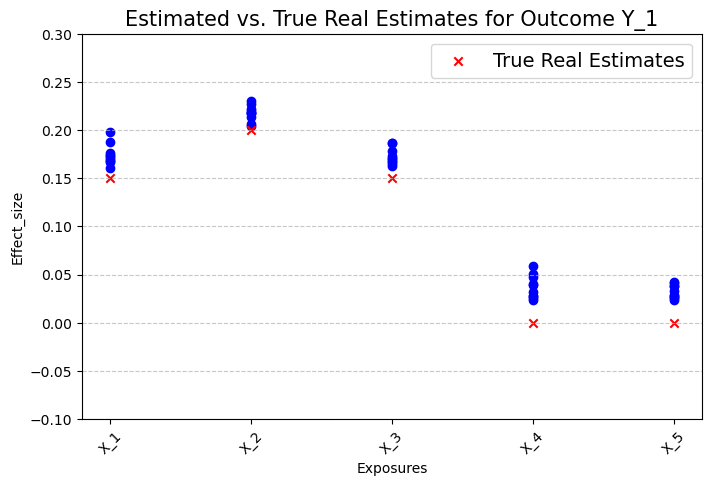

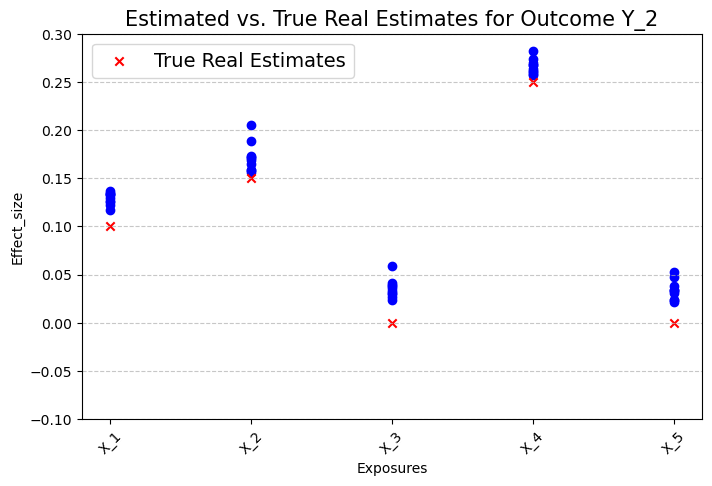

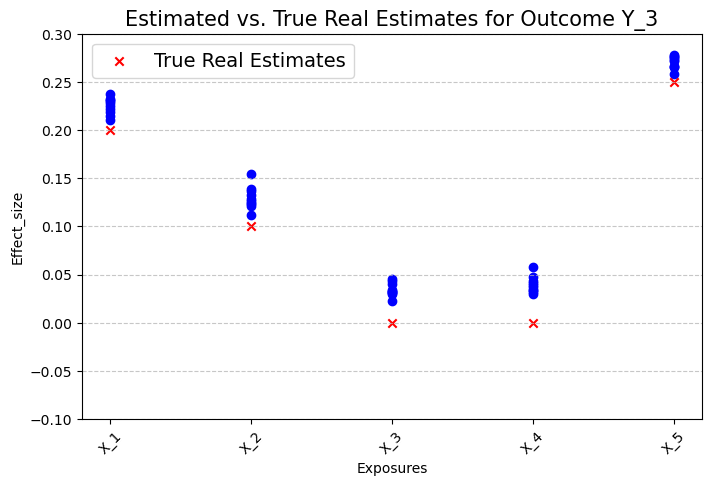

In [134]:
import matplotlib.pyplot as plt

# Number of exposures
num_exposures = len(estimated_effects_matrix.index)

# Define the exposure labels (X_1 to X_100)
exposure_labels = [f'X_{i}' for i in range(1, num_exposures + 1)]

# Define columns names of correlated_effect matrix
correlated_effect = pd.DataFrame(correlated_effect).rename(columns = {0:'Y_1', 1: 'Y_2', 2: 'Y_3'})
# Plot for each outcome
for outcome_column in estimated_effects_matrix.columns:
    # Extract estimated effects and true real estimates for the outcome
    estimated_effects = estimated_effects_matrix[outcome_column]
    true_real_estimates = correlated_effect[outcome_column]
    
    # Create a scatter plot with a larger x-axis
    plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
    # pdb.set_trace()
    for j in range(chunk_size):
        serie = []
        for i in range(5):
            serie.append(estimated_effects.iloc[i][j])
            #serie.append(estimated_effects_matrix.iloc[i,0][j])
        plt.scatter(range(1, num_exposures + 1), serie,color="blue") #  label='Estimated Effects'
    plt.scatter(range(1, num_exposures + 1), true_real_estimates, label='True Real Estimates', marker='x',color="red")
    
    # Add labels and title
    plt.xlabel('Exposures')
    plt.ylabel('Effect_size')
    plt.title(f'Estimated vs. True Real Estimates for Outcome {outcome_column}', fontsize = 15)
    
    # Set x-axis labels
    plt.xticks(range(1, num_exposures + 1), exposure_labels, rotation=45)
    plt.ylim(-0.1,0.3)
    
    # Add gridlines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=14)
    
    # Show the plot
    plt.show()

# MR multi-exposures 1 outcome

In [143]:
import pandas as pd
import statsmodels.api as sm
import pdb

# Split the DataFrame into chunks of "num_datasets" 
chunk_size = 10
scenar = 4
chunk = results_df.iloc[chunk_size*scenar:chunk_size*(scenar+1),:]
#chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

dataset = chunk.loc[chunk_size*scenar,"Base Dataset"]
estimated_effects_matrix = pd.DataFrame(index=dataset.columns[3:], columns=dataset.columns[:3])
estimated_effects_matrix.iloc[:,:] = [[[] for i in range(3)] for j in range(5)]

for dataset_index in range(chunk_size*scenar,chunk_size*(scenar+1)):
    # Extract exposures and outcomes
    dataset = chunk.loc[dataset_index,"Base Dataset"]
    dict_IVs = chunk.loc[dataset_index,"IV Indices"]
    IV = np.concatenate([dict_IVs[cle] for cle in dict_IVs.keys()])
    exposures = dataset.iloc[IV, 3:]  # Assuming exposures are in columns X_1 to X_5
    outcomes = dataset.iloc[IV, :3]   # Assuming outcomes are in columns Y_1, Y_2, Y_3

    # Initialize a matrix to store estimated effects
    num_exposures = exposures.shape[1]
    num_outcomes = outcomes.shape[1]

    # Fit OLS model for each pair of exposure and outcome

    for outcome_column in outcomes.columns:
        # pdb.set_trace()
            # grosse question : est ce qu'on prend tous le bloc d'exposures et tous le bloc d'outcomes comme avant
            # ou est ce qu'on prend seulement les SNPs IVs ?
        X = sm.add_constant(exposures)
        y = outcomes.loc[:,outcome_column]
        if len(y) > 0:
            model = sm.OLS(y, X).fit()
            #resultat = model.params.loc[exposure_column] # bug
            resultat = model.params.iloc[1:]
        else:
            resultat = None
            print("None",exposure_column,outcome_column)
        # Store the estimated effect in the matrix
        # pdb.set_trace()
        for i in range(len(resultat)):
            estimated_effects_matrix.loc[f"X_{i+1}",outcome_column].append(resultat.iloc[i])
            # estimated_effects_matrix.loc[:, outcome_column].append(model.params.loc[exposure_column])
print(estimated_effects_matrix)

# Print or use the estimated_effects_matrix as needed
#print(estimated_effects_matrix)

                                                   Y_1  \
X_1  [0.14958103222215902, 0.15051121116010063, 0.1...   
X_2  [0.18428236035872209, 0.19558878649033748, 0.2...   
X_3  [0.15359238118976792, 0.15142901976937953, 0.1...   
X_4  [-0.005493178138663855, 0.003965751978987419, ...   
X_5  [0.0036186307068518816, 0.0021180187599788634,...   

                                                   Y_2  \
X_1  [0.09248314685104772, 0.09631549977567974, 0.1...   
X_2  [0.13737822634651436, 0.14691028351824445, 0.1...   
X_3  [0.00480127123696982, -0.0015097010735110605, ...   
X_4  [0.2445279310359474, 0.25035996122479126, 0.25...   
X_5  [0.009046289663866757, 0.0027261026308797827, ...   

                                                   Y_3  
X_1  [0.1961471145584678, 0.19780731754965544, 0.19...  
X_2  [0.09081885875951323, 0.09839154549418545, 0.1...  
X_3  [0.0007401823072303452, -0.0015754189701517678...  
X_4  [-0.0053811122476736155, 0.005048975716208004,...  
X_5  [0.252628512

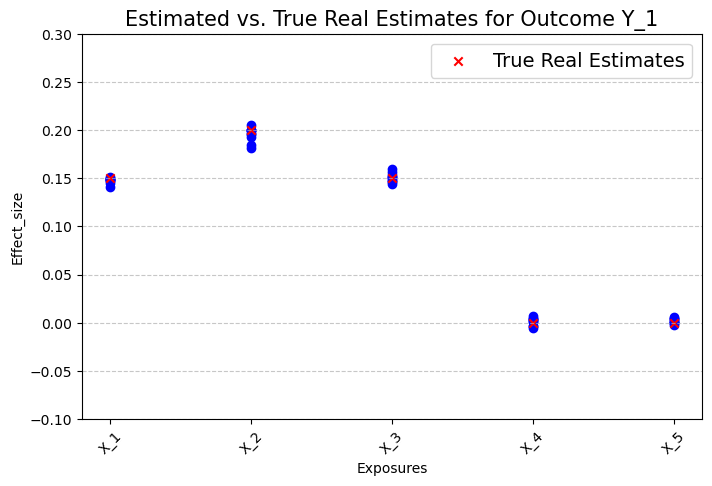

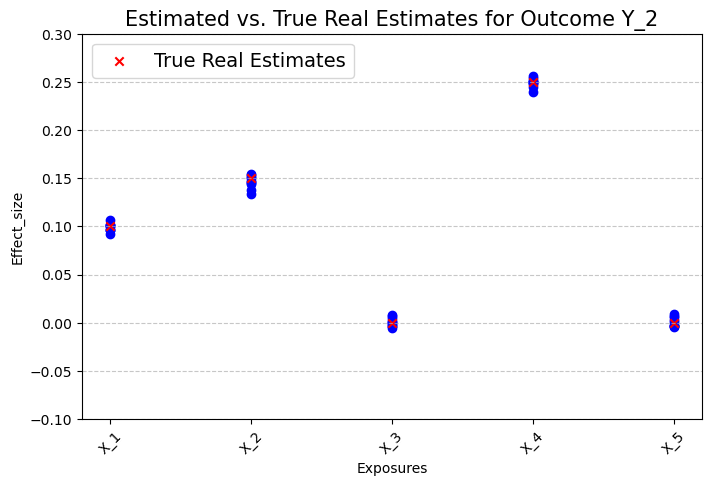

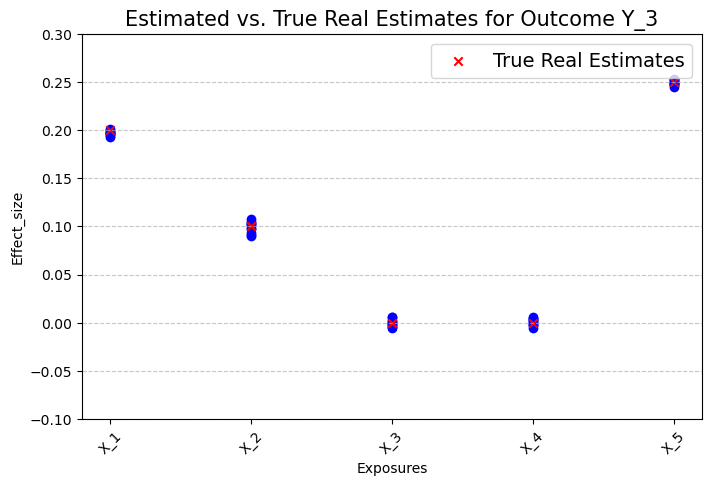

In [144]:
import matplotlib.pyplot as plt

# Number of exposures
num_exposures = len(estimated_effects_matrix.index)

# Define the exposure labels (X_1 to X_100)
exposure_labels = [f'X_{i}' for i in range(1, num_exposures + 1)]

# Define columns names of correlated_effect matrix
correlated_effect = pd.DataFrame(correlated_effect).rename(columns = {0:'Y_1', 1: 'Y_2', 2: 'Y_3'})
# Plot for each outcome
for outcome_column in estimated_effects_matrix.columns:
    # Extract estimated effects and true real estimates for the outcome
    estimated_effects = estimated_effects_matrix[outcome_column]
    true_real_estimates = correlated_effect[outcome_column]
    
    # Create a scatter plot with a larger x-axis
    plt.figure(figsize=(8, 5))  # Adjust the figsize as needed
    # pdb.set_trace()
    for j in range(chunk_size):
        serie = []
        for i in range(5):
            serie.append(estimated_effects.iloc[i][j])
            #serie.append(estimated_effects_matrix.iloc[i,0][j])
        plt.scatter(range(1, num_exposures + 1), serie,color="blue") #  label='Estimated Effects'
    plt.scatter(range(1, num_exposures + 1), true_real_estimates, label='True Real Estimates', marker='x',color="red")
    
    # Add labels and title
    plt.xlabel('Exposures')
    plt.ylabel('Effect_size')
    plt.title(f'Estimated vs. True Real Estimates for Outcome {outcome_column}', fontsize = 15)
    
    # Set x-axis labels
    plt.xticks(range(1, num_exposures + 1), exposure_labels, rotation=45)
    plt.ylim(-0.1,0.3)
    
    # Add gridlines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=14)
    
    # Show the plot
    plt.show()

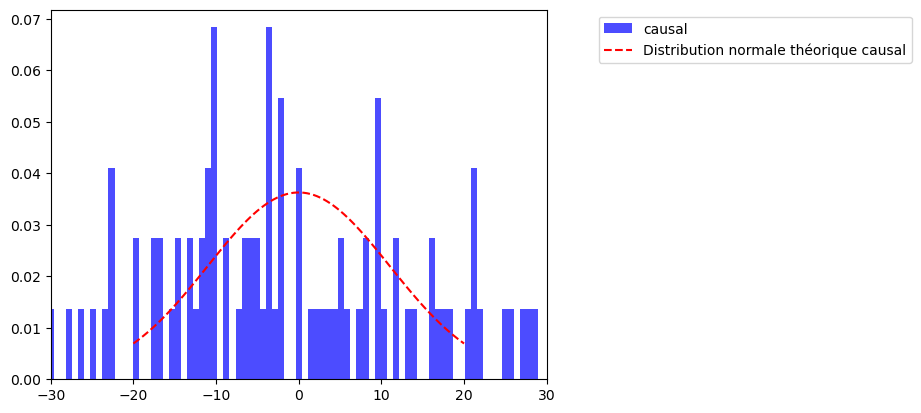

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# liste des variants causaux
liste_var_caus = results_df['Divided CV'].iloc[1][0]
# base_dataset
bd = results_df['Base Dataset'].iloc[1]
causal = bd.loc[liste_var_caus,"X_1"]
plt.hist(causal, bins=150, color='blue', alpha=0.7,label='causal',density=True)
#plt.hist(bd.loc[:,"X_1"], bins=100, color='orange', alpha=0.7,label='tous',density=True)
x = np.linspace(-20, 20, 100)
y = scipy.stats.norm.pdf(x, 0, 11)  # Distribution normale avec moyenne 0 et écart-type 3
plt.plot(x, y, 'r--', label='Distribution normale théorique causal')
y2 = scipy.stats.norm.pdf(x, 0, 1)
#plt.plot(x, y2, 'g--', label='Distribution normale théorique')
plt.xlim(-30, 30)
#plt.ylim(0, 30)
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 1))
plt.show()

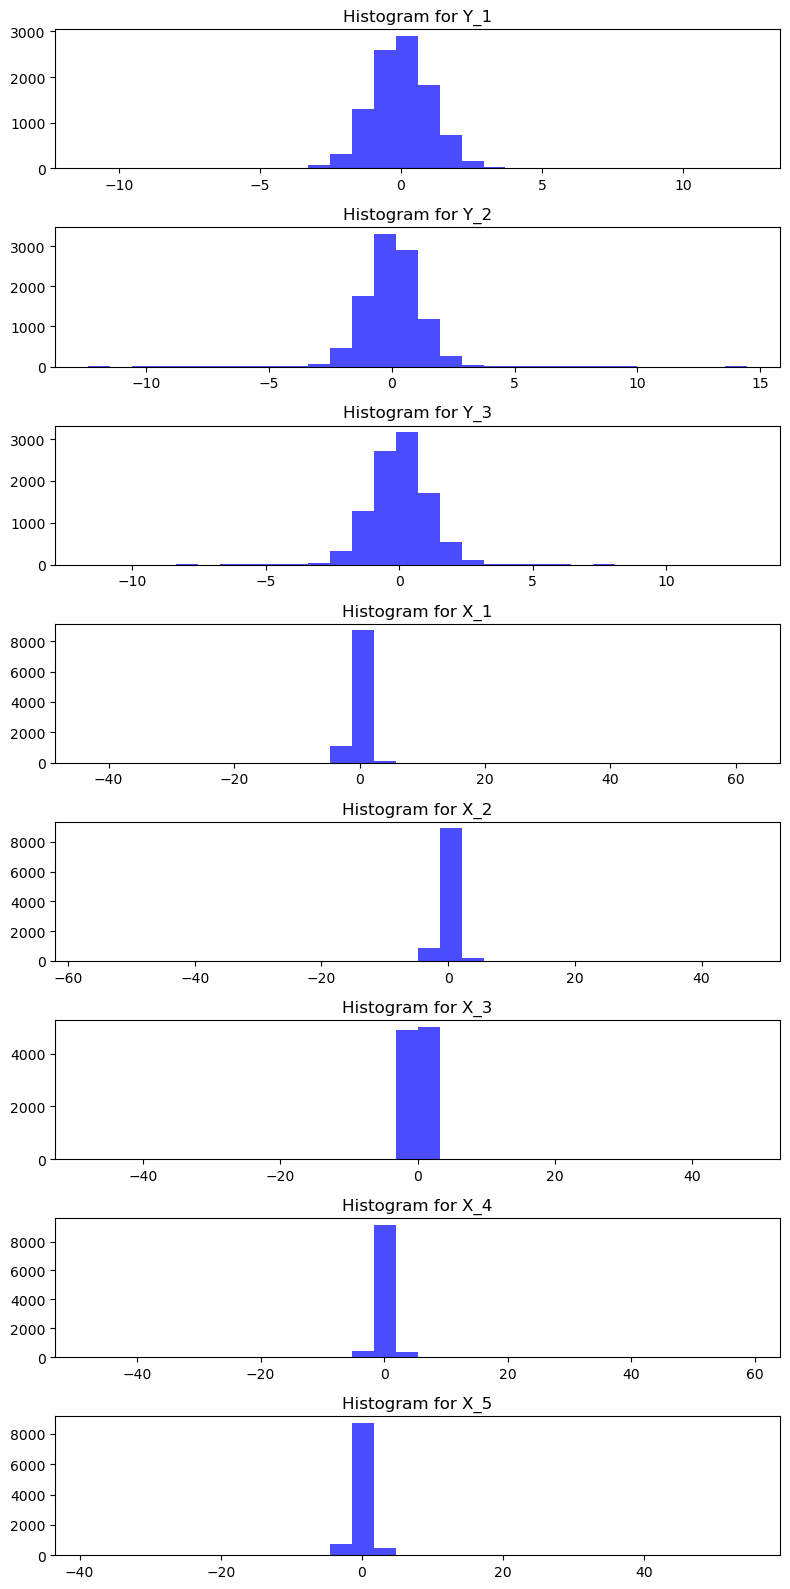

In [53]:
# Extract the betas datasets from the results dataframe
base_dataset = results_df['Base Dataset'].iloc[1]

# Get the number of columns (exposures and outcomes) in the dataset
num_columns = base_dataset.shape[1]

# Set up subplots for each column
fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, 2*num_columns))

# Flatten axes if there is only one column
axes = axes.flatten() if num_columns > 1 else [axes]

# Plot histograms for each column
for i in range(num_columns):
    axes[i].hist(base_dataset.iloc[:, i], bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'Histogram for {base_dataset.columns[i]}')

plt.tight_layout()
plt.show()

## Plot true effects vs estimated effects¶

TypeError: unhashable type: 'list'

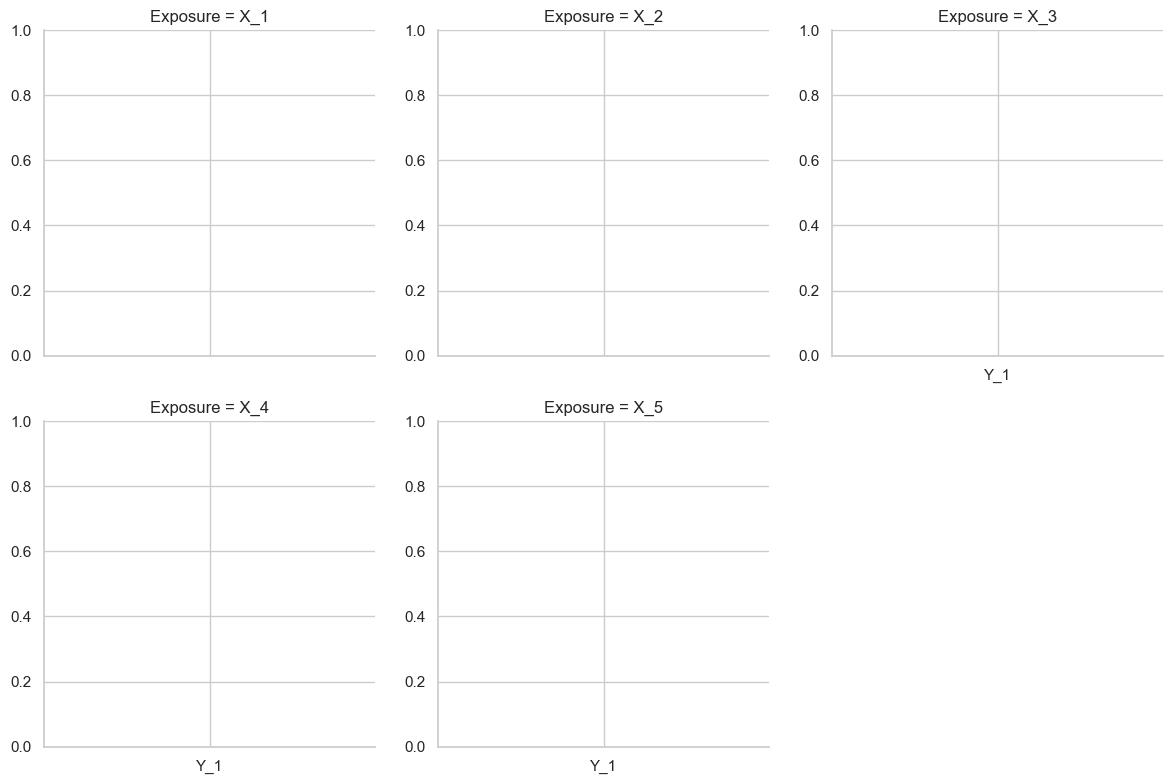

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust correlated effect indices
correlated_effect.index = ["X_1", "X_2", "X_3", "X_4", "X_5"]

# Convert estimated_effects_matrix to a long format for plotting
estimated_effects_long = estimated_effects_matrix.reset_index().melt(id_vars='index', var_name='Outcome', value_name='Estimated Effect')
estimated_effects_long.rename(columns={'index': 'Exposure'}, inplace=True)

# Convert correlated_effects to a long format
correlated_effects_long = correlated_effect.reset_index().melt(id_vars='index', var_name='Outcome', value_name='True Effect')
correlated_effects_long.rename(columns={'index': 'Exposure'}, inplace=True)

# Merge the two DataFrames on Exposure and Outcome columns
merged_effects = pd.merge(estimated_effects_long, correlated_effects_long, on=['Exposure', 'Outcome'])

# Convert Exposure column to categorical for proper ordering in the plot
merged_effects['Exposure'] = pd.Categorical(merged_effects['Exposure'], categories=exposure_labels, ordered=True)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting
g = sns.FacetGrid(merged_effects, col='Exposure', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.scatterplot, x='Outcome', y='Estimated Effect', marker='o', color='red', label='Estimated Effect')
g.map_dataframe(sns.scatterplot, x='Outcome', y='True Effect', marker='x', color='blue', label='True Effect')
g.add_legend()

# Set axis labels and titles
g.set_axis_labels("Outcome", "Effect Size")
g.set_titles(col_template="{col_name}")

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
merged_effects

,Exposure,Outcome,Estimated Effect,True Effect
0,X_1,Y_1,0.092358,0.15
1,X_2,Y_1,0.113488,0.20
2,X_3,Y_1,0.197806,0.15
3,X_4,Y_1,0.093368,0.00
4,X_5,Y_1,0.015383,0.00
5,X_1,Y_2,0.078946,0.10
6,X_2,Y_2,0.100572,0.15
7,X_3,Y_2,0.038683,0.00
8,X_4,Y_2,0.282254,0.25
9,X_5,Y_2,0.002345,0.00


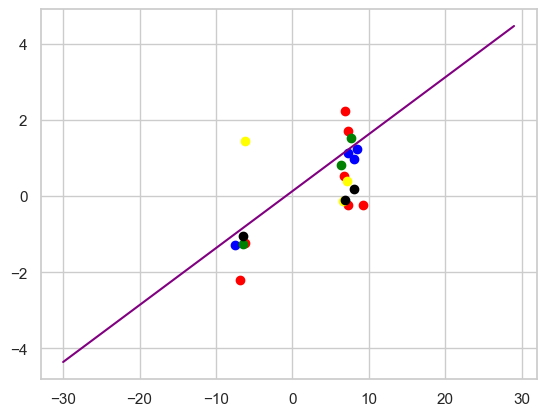

In [11]:
import matplotlib.pyplot as plt
x = np.array([i for i in range(-30,30,1)])
#     X = sm.add_constant(exposures.loc[dico[exposure_column],exposure_column])
#     y = outcomes.loc[dico[exposure_column],outcome_column]
plt.scatter(exposures.loc[dico["X_1"],"X_1"],outcomes.loc[dico["X_1"],"Y_1"],label="1",color="blue")
plt.scatter(exposures.loc[dico["X_2"],"X_2"],outcomes.loc[dico["X_2"],"Y_1"],label="2",color="red")
plt.scatter(exposures.loc[dico["X_3"],"X_3"],outcomes.loc[dico["X_3"],"Y_1"],label="3",color="green")
plt.scatter(exposures.loc[dico["X_4"],"X_4"],outcomes.loc[dico["X_4"],"Y_1"],label="4",color="yellow")
plt.scatter(exposures.loc[dico["X_5"],"X_5"],outcomes.loc[dico["X_5"],"Y_1"],label="5",color="black")
plt.plot(x, 0.149415 * x + 0.126813, color='purple', label='Régression linéaire')
# median_value = exposures['X_1'].median()
# x = exposures[exposures['X_1'] < median_value]['X_1'].values
# y = outcomes[exposures['X_1'] < median_value]['Y_1'].values

In [12]:
import statsmodels.api as sm
sm.OLS(outcomes["Y_1"], sm.add_constant(exposures)).fit().params

const   -0.216034
X_1      0.092358
X_2      0.113488
X_3      0.197806
X_4      0.093368
X_5      0.015383
dtype: float64

In [13]:
# méthode classique
np.polyfit(exposures["X_1"], outcomes["Y_1"], 1)

array([ 0.12482783, -0.06078743])

In [14]:
# IVW
scenar = 3
IVs = results_df['IV Indices'].iloc[scenar]
exposures = results_df.loc[scenar,"Base Dataset"].iloc[IVs, 3:]
outcomes = results_df.loc[scenar,"Base Dataset"].iloc[IVs, :3]
for outcome_column in outcomes.columns:
    stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        N = sum((exposures[exposure_column]**2)*(stdY**-2)*B)
        D = sum((exposures[exposure_column]**2)*(stdY**-2))
        print(N/D)

0.1372805228718571
0.14852098020452453
0.15489033891520293
-0.008243035589995467
0.010860366185837403
0.09410920845216333
0.09750983948853152
0.014978896217214925
0.2352094867333532
0.03380940487214923
0.15548984005214125
0.09832565473319739
0.0038887049978205265
0.006751409998144389
0.25350819663831925


In [15]:
# IVW
scenar = 3
IVs = results_df['IV Indices'].iloc[scenar]
exposures = results_df.loc[scenar,"Base Dataset"].iloc[:, 3:]
outcomes = results_df.loc[scenar,"Base Dataset"].iloc[:, :3]
for outcome_column in outcomes.columns:
    stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        Z = np.polyfit(exposures[exposure_column], outcomes[outcome_column], 1)
        N = sum((exposures[exposure_column]**2)*(stdY**-2)*B)
        D = sum((exposures[exposure_column]**2)*(stdY**-2))
        print(N/D)

0.0943017526201804
0.09581494642544602
0.0885487831237427
0.003973472281121384
0.007670384701930444
0.061316691585727875
0.060766784780393324
0.011057423300573953
0.12712394581154224
0.018896759399347363
0.10209257140535524
0.06522585581543937
0.007304892715953893
0.002989193523388582
0.12166138935398921


In [16]:
# Median-based
for outcome_column in outcomes.columns:
    for exposure_column in exposures.columns:
        B = outcomes[outcome_column]/exposures[exposure_column]
        print(B.median())

0.039159883085407174
0.014415576009766907
0.01900364800898143
0.033459074285340104
0.006113388493973228
0.00856686597323822
0.005873865554982338
-0.001766247561334571
0.022894137182804027
0.023817729870272586
0.010168014815370418
0.02281303217826608
-0.011137409106252803
0.009527999124380715
0.00633342007573564


In [61]:
# Weighted Median Estimator
# for outcome_column in outcomes.columns:
#     stdY = results_df.loc[scenar,"Standard Deviation"][outcome_column]
#     for exposure_column in exposures.columns:
#         B = outcomes[outcome_column]/exposures[exposure_column]
#         W = exposures[exposure_column]**2/stdY**2
#         R = W/sum(W)
#         R = np.cumsum(R)
#         indice = np.where(R.values>0.5)[0][0]
#         BWM = B.iloc[indice-1]+(B.iloc[indice]-B.iloc[indice-1])*((0.5-R.iloc[indice-1])/(R.iloc[indice]-R.iloc[indice-1]))
#         print(R.iloc[indice-1],B.iloc[indice-1],BWM)

In [35]:
# import pandas as pd
# import statsmodels.api as sm
# import pdb

# # Split the DataFrame into chunks of "num_datasets" 
# chunk_size = 10
# scenar = 1
# chunk = results_df.iloc[chunk_size*scenar:chunk_size*(scenar+1),:]
# #chunks = [results_df.iloc[i:i + chunk_size] for i in range(0, len(results_df), chunk_size)]

# dataset = chunk.loc[chunk_size*scenar,"Base Dataset"]
# estimated_effects_matrix = pd.DataFrame(index=dataset.columns[3:], columns=dataset.columns[:3])
# estimated_effects_matrix.iloc[:,:] = [[[] for i in range(3)] for j in range(5)]

# for dataset_index in range(chunk_size*scenar,chunk_size*(scenar+1)):
#     # Extract exposures and outcomes
#     dataset = chunk.loc[dataset_index,"Base Dataset"]
#     dict_IVs = chunk.loc[dataset_index,"IV Indices"]
#     exposures = dataset.iloc[:, 3:]  # Assuming exposures are in columns X_1 to X_5
#     outcomes = dataset.iloc[:, :3]   # Assuming outcomes are in columns Y_1, Y_2, Y_3

#     # Initialize a matrix to store estimated effects
#     num_exposures = exposures.shape[1]
#     num_outcomes = outcomes.shape[1]

    
#     dtf_exposures = pd.DataFrame()
    
#     # Fit OLS model for each pair of exposure and outcome
#     for outcome_column in outcomes.columns:
#         # pdb.set_trace()
#         for exposure_column in exposures.columns:
#             # grosse question : est ce qu'on prend tous le bloc d'exposures et tous le bloc d'outcomes comme avant
#             # ou est ce qu'on prend seulement les SNPs IVs ?
#             dtf_exposures = pd.concat([dtf_exposures,exposures.loc[dict_IVs[exposure_column],exposure_column]],axis=1)
#         # pdb.set_trace()
#         X = sm.add_constant(dtf_exposures)
#         y = outcomes.loc[dtf_exposures.index,outcome_column]
#         if len(y) > 0:
#             model = sm.OLS(y, X).fit() # , missing="drop"
#             resultat = model.params.loc[exposure_column]
#         else:
#             resultat = None
#             print("None",exposure_column,outcome_column)
#             # Store the estimated effect in the matrix
#         estimated_effects_matrix.at[exposure_column, outcome_column].append(resultat)
#             # estimated_effects_matrix.loc[:, outcome_column].append(model.params.loc[exposure_column])
# print(estimated_effects_matrix)

# # Print or use the estimated_effects_matrix as needed
# #print(estimated_effects_matrix)